# Create an ESN for sepsis shared features (trial 1)

## Config

In [12]:
path = '../training/'
isTraining = True
isTesting = not isTraining
ESN_function = 'sigmoid'
gkfold_split = 10
norm_feat_pat = False
change_feature = False
nan_process_load = False
nan_process = True
nan_to_zero = True
biased_regress = True
normal_equations = True
example_ESN=True
numpy_load = True


from os import listdir
print(len(listdir(path))-int('README.md' in (listdir(path))), 'files')

def print_config(path, isTraining, isTesting, ESN_function, gkfold_split):
    print("Path: ", path)
    print("isTraining: ", isTraining)
    print("isTesting: ", isTesting)
    print("ESN func: ", ESN_function)
    print("gkfold_split: ", gkfold_split)
    return

print_config(path, isTraining, isTesting, ESN_function, gkfold_split)

40336 files
Path:  ../training/
isTraining:  True
isTesting:  False
ESN func:  sigmoid
gkfold_split:  10


## Load ICU sepsis data log

In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as m
from os import listdir
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

In [14]:
fnames = listdir(path)  
fnames.sort()
if 'README.md' in fnames:
    fnames.remove('README.md')
fnames[-1]

'p120000.psv'

In [15]:
# Count sample patients
sample_num = len(fnames)
sample_num

40336

In [16]:
# Import and print dataframe layout
def loadICUdata(fname, printdf = False):
    df = pd.read_csv(fname, sep = '|')
    #print(fname, ' file:')
    if printdf:
        print(df)
    return df

print(fnames[0])
# Example with first patient 
df = loadICUdata(path + fnames[0], False)
df

p000001.psv


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0
5,110.0,91.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,6,0
6,108.0,92.0,36.11,123.0,77.00,NaN,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,7,0
7,106.0,90.5,NaN,93.0,76.33,NaN,29.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,8,0
8,104.0,95.0,NaN,133.0,88.33,NaN,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,9,0
9,102.0,91.0,NaN,134.0,87.33,NaN,30.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,10,0


## Sepsis keys for the ESN

In [17]:
# We use features defined by the user
s_keys = []
with open(path + fnames[0], 'r') as f:
    header = f.readline().strip()
    s_keys = header.split('|')
    
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
type(s_keys)
len(s_keys)

41

In [18]:
if numpy_load:
    feature_matrix = np.load('../npy/training_AB.npy')
    sepsis_label = np.load('../npy/training_AB_Y.npy')
    patient = np.load('../npy/training_AB_patient.npy')

In [19]:
print(feature_matrix.shape)
print(sepsis_label.shape)
print(patient.shape)

(1552210, 40)
(1552210, 1)
(1552210, 1)


In [20]:
print(feature_matrix[0,:])

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan  8.314e+01  0.000e+00
        nan        nan -3.000e-02  1.000e+00]


In [21]:
type(feature_matrix[0])

numpy.ndarray

In [22]:
feature_matrix
np.shape(feature_matrix)

(1552210, 40)

In [23]:
# Keep a raw copy
raw_feature_matrix = np.copy(feature_matrix)

In [24]:
patient
np.shape(patient)

(1552210, 1)

In [25]:
sepsis_label
np.shape(sepsis_label)

(1552210, 1)

In [26]:
# Single entry example
i_e = 90000
print(patient[i_e])
print(feature_matrix[i_e,:])
print(sepsis_label[i_e])


[2310]
[ 1.070e+02  9.900e+01        nan  1.410e+02  8.300e+01        nan
  1.500e+01        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan  5.646e+01  1.000e+00
        nan        nan -5.000e-02  1.000e+01]
[0]


In [27]:
type(s_keys)

list

In [28]:
if 'HR' in s_keys:
    print(feature_matrix[:,s_keys.index('HR')]) 
    print(len(feature_matrix[:,s_keys.index('HR')]))

[nan 97. 89. ... 78. 82. 80.]
1552210


45 entries x 40


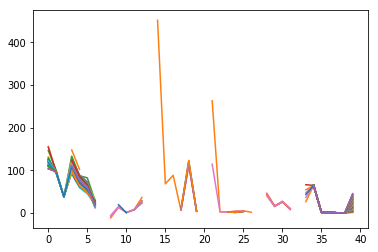

In [29]:
i_pat = 6

def plot_patient_features(n_pat, features, patient_array):
    plot_j = np.where(patient == n_pat)[0]
    for j in range (len(plot_j)):
        plt.plot(features[plot_j[j],:])    
    print(len(plot_j), "entries x", np.shape(features)[1])
    return

def print_patient_features(n_pat, features, patient_array):
    print("Patient", n_pat)
    print_j = np.where(patient == n_pat)[0]
    for j in range (len(print_j)):
        print(features[print_j[j],:])    
    return

plot_patient_features(i_pat, feature_matrix, patient)

## NaN process

In [30]:
feature_matrix= np.copy(raw_feature_matrix)

In [31]:
if nan_process and nan_to_zero:
    feature_matrix = np.nan_to_num(feature_matrix)
    print("Changed nan to 0")

Changed nan to 0


## Preprocess features (log(-HospAdmTime-1))

In [32]:
if change_feature:
    feat_i = s_keys.index('HospAdmTime')
    print(np.min(raw_feature_matrix[:,feat_i]), np.max(raw_feature_matrix[:,feat_i]))
    argmin = (np.argmin(raw_feature_matrix[:,feat_i]))
    print(argmin, patient[argmin])

In [33]:
if change_feature:
    change_i = np.where(raw_feature_matrix[:,feat_i]!=np.nan)[0]
    print(len(change_i))
    change_i

In [34]:
if change_feature:
    feature_matrix[change_i,feat_i] = np.log(1-np.copy(raw_feature_matrix[change_i,feat_i]))
    # for i in range(len(change_i)):
    for i in range(50):
        print(raw_feature_matrix[change_i[i],feat_i],feature_matrix[change_i[i],feat_i])

In [35]:
if change_feature:
    print(np.min(feature_matrix[:,feat_i]), np.max(feature_matrix[:,feat_i]))
    plt.plot(feature_matrix[change_i,feat_i])

In [36]:
print(np.min(feature_matrix), np.max(feature_matrix[:,:19]))

-5366.86 9961.0


## Mapminmax normalise scale per feature per patient

In [37]:
if norm_feat_pat:
    for i in range(len(DATA)):
        i_pat = np.where(patient==i)[0]
        scaler = MinMaxScaler()
        scaler.fit(feature_matrix[i_pat,:5])
        feature_matrix[i_pat,:5] = scaler.transform(feature_matrix[i_pat,:5])
        
# Per single feature
#         for j in range(np.shape(feature_matrix)[1]):
#             scaler.fit(feature_matrix[i_pat,j])
#             feature_matrix[i_pat,j] = scaler.transform(feature_matrix[i_pat,j])

## Divide in sets

In [38]:
# from sklearn.model_selection import GroupKFold
# X = feature_matrix
# y = sepsis_label
# groups = patient

# from sklearn.utils import shuffle
# X_shuffled, y_shuffled, groups_shuffled = shuffle(X, y, groups, random_state=0)

# gkf = GroupKFold(n_splits=gkfold_split)

In [39]:
# print(np.min(X_shuffled), np.max(X_shuffled))

NameError: name 'X_shuffled' is not defined

## Create an ESN

#### Create rand masks (input weight)
#### M⊂[-1,1]
#### Mb⊂[-1,1]

In [40]:
# ESN Parameters
N = 200      # Neurons
mem = 0.1    # memory
scale = 0.2  # scaling factor

In [41]:
# Nonlinear mapping function
def sigmoid(x, exponent):
    return 1/(1+np.exp(-exponent*x))-0.5

def rectify(x, slope):
    return slope*np.asarray(x>0, dtype=np.double)*x

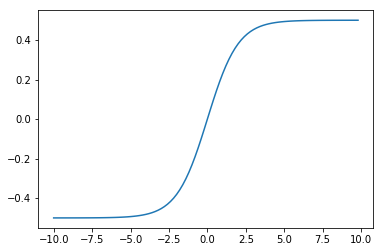

In [42]:
sigmoid_exponent = 1
rect_slope = 1
if ESN_function == 'sigmoid':
    func = sigmoid
elif ESN_function == 'rect':
    func = rectify
a = np.linspace(-10, 10, 100, False)
b = func(a,sigmoid_exponent)
plt.plot(a,b)

In [43]:
# Mask parameters
M = 2*np.random.rand(np.shape(feature_matrix)[1],N)-1
Mb = 2*np.random.rand(1,N)-1
print(np.shape(M))
print(np.shape(Mb))
print(np.min(M), np.max(M))
print(np.min(Mb), np.max(Mb))


(40, 200)
(1, 200)
-0.9999482780732696 0.9999276984981407
-0.9878227505803225 0.9997510401146723


In [44]:
print(len(s_keys))
print("SepsisLabel" in s_keys)

41
True


In [45]:
# Create ESN 
def feedESN(features, mask, mask_bias, scale, mem):
    ESN = np.ones((np.shape(features)[0],N), dtype=np.double)
    IN = np.matmul(features, M) + np.repeat(Mb, np.shape(features)[0], axis=0)
    print(np.shape(IN))
    print(np.min(IN), np.max(IN))
    p = np.zeros((1,N),dtype=np.double)
    for i in range(np.shape(features)[0]):
        i
        in_val = scale*IN[i,:]+p*mem
        ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
        p = np.copy(np.roll(ESN[i,:],1))
    return ESN

In [50]:
# Create ESN 
import numba
@numba.jit
def feedESNjit(features, mask, mask_bias, scale, mem):
    ESN = np.ones((np.shape(features)[0],N), dtype=np.double)
    IN = np.matmul(features, M) + np.repeat(Mb, np.shape(features)[0], axis=0)
    print(np.shape(IN))
    print(np.min(IN), np.max(IN))
    p = np.zeros((1,N),dtype=np.double)
    for i in range(np.shape(features)[0]):
        i
        in_val = scale*IN[i,:]+p*mem
        ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
        p = np.copy(np.roll(ESN[i,:],1))
    return ESN

In [46]:
# if example_ESN:
#     ESN = feedESN(feature_matrix, M, Mb, scale, mem)
#     print(np.min(ESN), np.max(ESN))

In [48]:
#Feed ESN
ESN = feedESN(feature_matrix, M, Mb, scale, mem)

(1552210, 200)
-10119.356851029153 10248.913409498758


In [51]:
ESNjit = feedESNjit(feature_matrix, M, Mb, scale, mem)

(1552210, 200)
-10119.356851029153 10248.913409498758


In [52]:
# Divide in sets
X = ESN
y = sepsis_label
groups = patient

from sklearn.utils import shuffle
X_shuffled, y_shuffled, groups_shuffled = shuffle(X, y, groups, random_state=0)

gkf = GroupKFold(n_splits=gkfold_split)

In [53]:
# if example_ESN:
#     if biased_regress:
#         ESNx = (np.hstack((ESN, np.ones((np.shape(ESN)[0],1), dtype=np.double))))
#         if normal_equations:
#             ESNt = np.transpose(ESNx)
#             ESNinv = np.linalg.pinv(np.matmul(ESNt,ESNx))
#             ESNaux = np.matmul(ESNinv, ESNt)
#             w = np.matmul(ESNaux, sepsis_label)
#         else:
#             ESNinv = np.linalg.pinv(ESNx)
#             w = np.matmul(ESNx, sepsis_label)
        
#         Y_pred = (np.matmul(ESNx,w))

#     else:
#         ESNinv = np.linalg.pinv(ESN)
#         w = np.matmul(ESNinv, sepsis_label)
#         Y_pred = (np.matmul(ESN,w))


#     print(np.shape(ESNinv))
#     print('auc: ', roc_auc_score(sepsis_label, Y_pred))

In [54]:
#MODIFIED
# if example_ESN:
#     if biased_regress:
#         ESNx = (np.hstack((ESN, np.ones((np.shape(ESN)[0],1), dtype=np.double))))
#         if normal_equations:
#             ESNt = np.transpose(ESNx)
#             ESNinv = np.linalg.pinv(np.matmul(ESNt,ESNx))
#             ESNaux = np.matmul(ESNinv, ESNt)
#             w = np.matmul(ESNaux, sepsis_label)
#         else:
#             ESNinv = np.linalg.pinv(ESNx)
#             w = np.matmul(ESNx, sepsis_label)
        
#         Y_pred = (np.matmul(ESNx,w))

#     else:
#         ESNinv = np.linalg.pinv(ESN)
#         w = np.matmul(ESNinv, sepsis_label)
#         Y_pred = (np.matmul(ESN,w))


#     print(np.shape(ESNinv))
#     print('auc: ', roc_auc_score(sepsis_label, Y_pred))

In [55]:
def get_weights_biasedNE(ESN, target):
    ESNx = (np.hstack((ESN, np.ones((np.shape(ESN)[0],1), dtype=np.double))))
    ESNt = np.transpose(ESNx)
    ESNinv = np.linalg.pinv(np.matmul(ESNt,ESNx))
    ESNaux = np.matmul(ESNinv, ESNt)
    w = np.matmul(ESNaux, target)
    return w, ESNaux

def get_weights_biased(ESN, target):
    ESNx = (np.hstack((ESN, np.ones((np.shape(ESN)[0],1), dtype=np.double))))
    ESNinv = np.linalg.pinv(ESNx)
    w = np.matmul(ESNinv, target)
    return w, ESNinv
    

In [56]:
#Loop realisations
for train_index, test_index in gkf.split(X_shuffled, y_shuffled, groups_shuffled):
    X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]
#     ESN = feedESN(X_train, M, Mb, scale, mem)
    
    if biased_regress:
        if normal_equations:
            w, ESNaux = get_weights_biasedNE(X_train, y_train)
            ESNx = (np.hstack((X_train, np.ones((np.shape(X_train)[0],1), dtype=np.double))))

        else:
            w, ESNaux = get_weights_biased(X_train, y_train)
            ESNx = (np.hstack((X_train, np.ones((np.shape(X_train)[0],1), dtype=np.double))))


        Y_pred = (np.matmul(ESNx,w))

        
    else:
        ESNinv = np.linalg.pinv(X_train)
        ESNaux = ESNinv
        w = np.matmul(ESNaux, y_train)

#        ESNtest = feedESN(X_test, M, Mb, scale, mem)
        Y_pred = (np.matmul(X_train,w))

    print(np.shape(ESNaux))

#     cm = confusion_matrix(y_test, Y_pred)
#     print(cm[0,0],cm[0,1])
#     print(cm[1,0],cm[1,1])
    print('auc: ', roc_auc_score(y_train, Y_pred))
    k = 1
    if k > 0:
        break

(201, 1396993)
auc:  0.7292412282704339


In [84]:
from sklearn.metrics import f1_score
th_step = 0.001
th_i = -0.07
th_steps = 1000
thsum = 0
th = np.zeros((1000, 1), dtype = np.double)
f1 =np.zeros((1000, 1), dtype = np.double)

print(th_i, th_i+th_step*th_steps)
for i in range(th_steps):
    th[i] = -0.07+ i * th_step
    f1[i] = f1_score(y_train, Y_pred > th[i])
    thsum = thsum + th[i]
#     print(i, th[i], f1[i])
    if i%100 == 0:
        print(i, th[i], f1[i])

    if f1[i] < 0.001 and thsum > 0:
        th = th[:i]
        f1 = f1[:i]
        break



-0.07 0.9299999999999999
0 [-0.07] [0.03504863]
1 [-0.069] [0.03504863]
2 [-0.068] [0.03504863]
3 [-0.067] [0.03504863]
4 [-0.066] [0.03504863]
5 [-0.065] [0.03504863]
6 [-0.064] [0.03504863]
7 [-0.063] [0.03504863]
8 [-0.062] [0.03504863]
9 [-0.061] [0.03504866]
10 [-0.06] [0.03504871]
11 [-0.059] [0.03504871]
12 [-0.058] [0.0350474]
13 [-0.057] [0.03504745]
14 [-0.056] [0.03504745]
15 [-0.055] [0.03504745]
16 [-0.054] [0.03504745]
17 [-0.053] [0.03504752]
18 [-0.052] [0.03504757]
19 [-0.051] [0.03504762]
20 [-0.05] [0.03504769]
21 [-0.049] [0.03504779]
22 [-0.048] [0.03504799]
23 [-0.047] [0.03504806]
24 [-0.046] [0.03504816]
25 [-0.045] [0.03504833]
26 [-0.044] [0.03504853]
27 [-0.043] [0.03504875]
28 [-0.042] [0.03504902]
29 [-0.041] [0.0350493]
30 [-0.04] [0.03504971]
31 [-0.039] [0.03505016]
32 [-0.038] [0.03505058]
33 [-0.037] [0.03505102]
34 [-0.036] [0.03505164]
35 [-0.035] [0.03505253]
36 [-0.034] [0.03505218]
37 [-0.033] [0.03505052]
38 [-0.032] [0.03505178]
39 [-0.031] [0.0

In [87]:
th_max = th[np.argmax(f1)]
print(np.min(Y_pred), np.max(Y_pred))
print('acc: ', accuracy_score(y_train, Y_pred > th_max))
print('f1: ', f1[np.argmax(f1)])

-0.07105676588376358 0.19967596484745526
acc:  0.952284657117108
f1:  [0.14857581]


### Report

In [ ]:
# Report config
if norm_feat_pat:
    print ("norm")
    print(scaler)
else: 
    print("not norm")
print("func: ", func)
print("func_argument: ", sigmoid_exponent, rect_slope)
print("mem: ", mem)
print("scale: ", scale)
print("auc: ", auc)
